# Williams vs ATP Top 500
Group 18 Project Proposal by: Sandra Radic, Charlie Sushams, Alex Grinius, & Clare Vu

## Introduction

In the world of sports, events are often divided between males and females for fairness. Therefore, female and male statistics are not usually compared in one group. However, there are many outstanding female players that could very well pose as serious competition to the male dominated sport - 23-time Grand Slam champion Serena Williams is definitely one of them. Williams is ranked number 1 in women's tennis, and started her professional career in her early teenage years, reflecting her exceptional skill. This leads to our question: How would Serena Williams rank amongst the top 500 male players? Our group intends to analyze the factors that separate men's and women's sports, and use them in a classification model to predict which category (ranks from 1 - 501 players) Williams would fall under if she were to partake in a male-only tournament. To conduct this analysis, we will be using the Player Stats for Top 500 players dataset, from  https://www.ultimatetennisstatistics.com/. We will focusing on height, number of seasons played, and the age the player began their professional career. This will allow us to examine whether physical stature serves as a male advantage or not, and otherwise compares skill level. Consequently, we will be creating categories using the "best rank" column to further sort our data and choose a new rank level for Serena. 

## Preliminary exploratory data analysis:

In [7]:
library(tidyverse)
library(tidymodels)
library(cowplot)
library(scales)
library(stringr)

Warning message:
"Missing column names filled in: 'X1' [1]"

-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)
i Use `spec()` for the full column specifications.




Best_career_rank_to_date,Height_cm,Seasons,Name,Year_turned_pro,Age,Birthdate,Age_turned_pro
<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
44,185,14,Lukas Lacko,2005,32,1987,18
17,193,11,Bernard Tomic,2008,27,1992,16
31,NA,5,Hubert Hurkacz,2015,22,1997,18
4,NA,5,Daniil Medvedev,2014,23,1996,18
47,NA,3,Miomir Kecmanovic,2017,20,1999,18
19,190,14,Marcel Granollers,2003,33,1986,17
11,198,15,Sam Querrey,2006,32,1987,19
9,178,16,Fabio Fognini,2004,32,1987,17
23,180,11,Dusan Lajovic,2007,29,1990,17


mean_height_cm,mean_number_pro_seasons,mean_age_turned_pro
<dbl>,<dbl>,<dbl>
185.6279,6.558824,18.03933


Warning message:
"Removed 286 rows containing missing values (geom_point)."
Warning message:
"Removed 100 rows containing missing values (geom_point)."
Warning message:
"Removed 194 rows containing missing values (geom_point)."


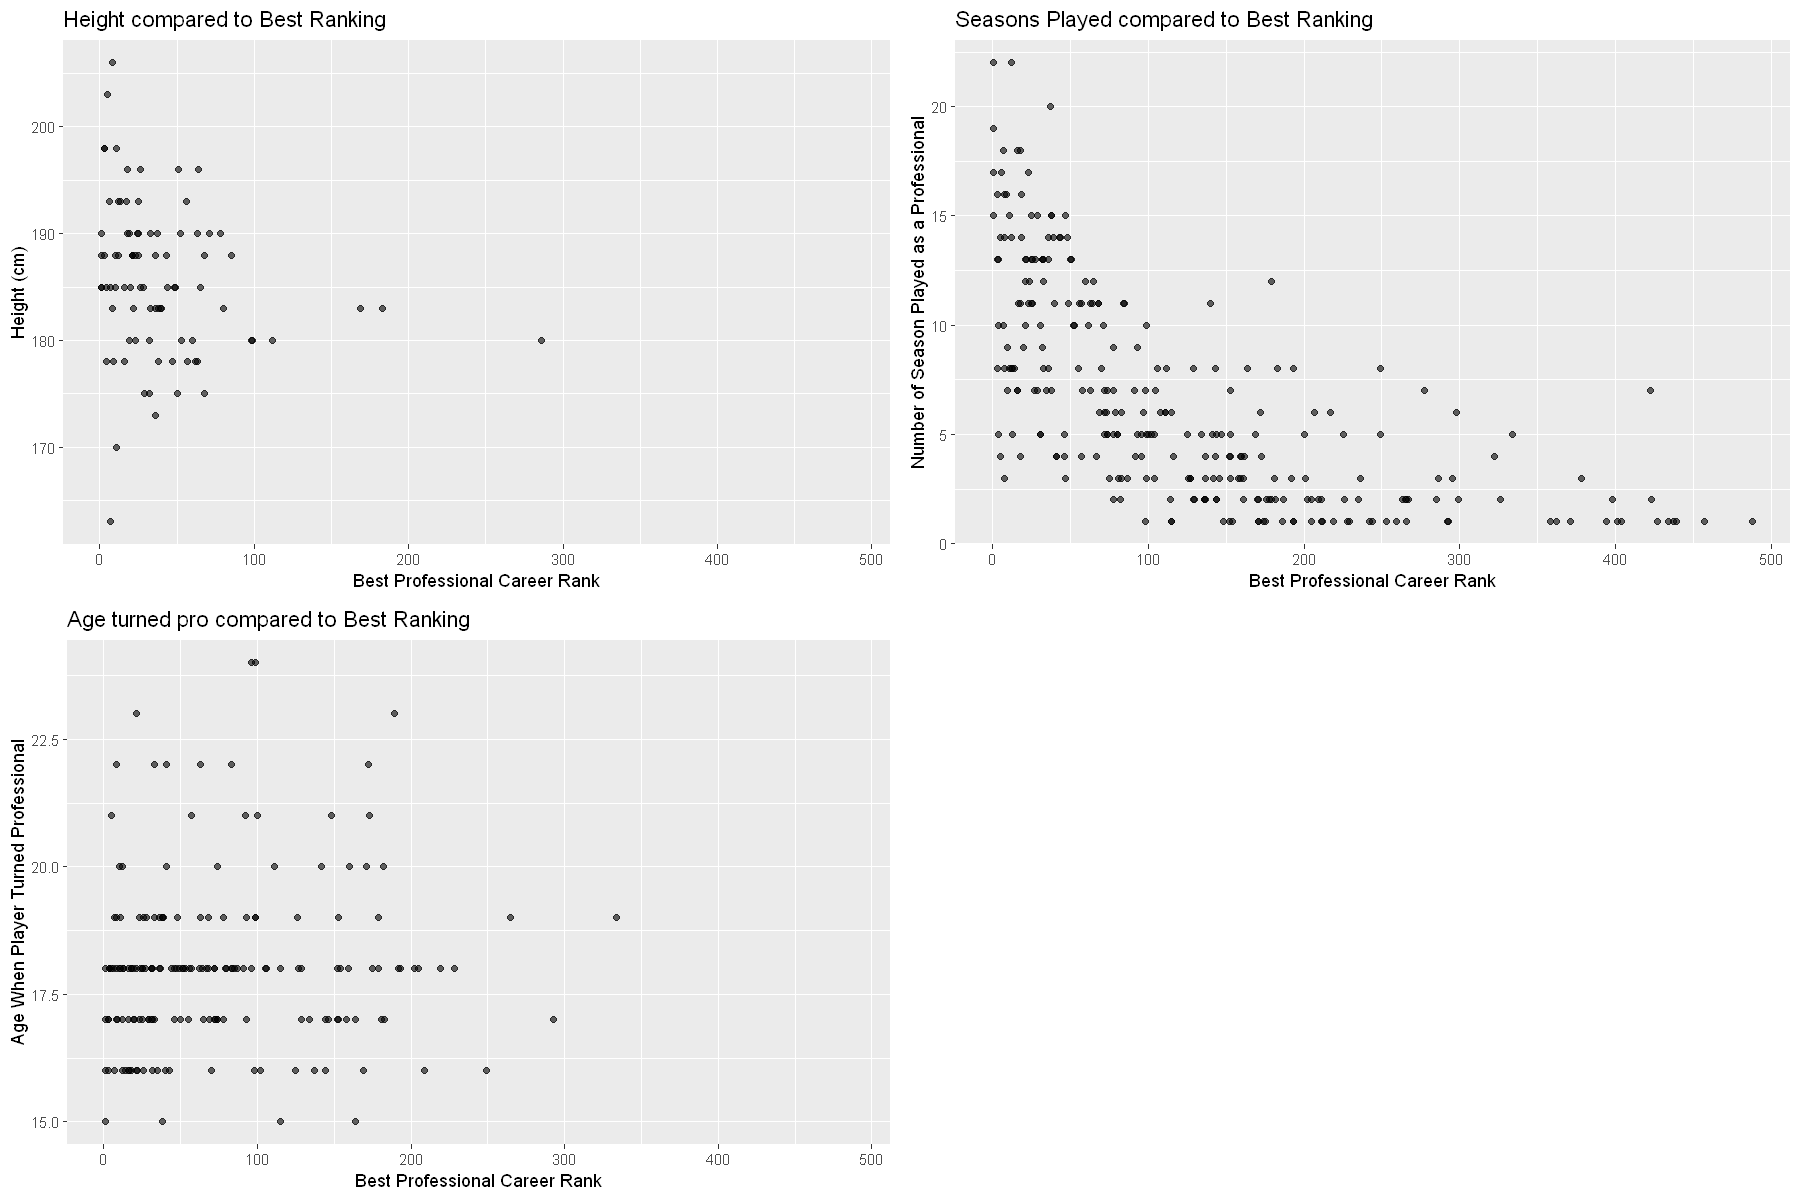

In [17]:
#read in data
player_stats <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

# select only the necessary columns

player_stats_filtered <- player_stats %>%
    select("Best Rank", Height, Seasons, Name, "Turned Pro", Age)
    


    
# tidy up dataframe (ensure correct datatypes and appropriate column names)

player_stats_tidy <- player_stats_filtered %>%
    separate(col = Age, into = c("Age", "Birthdate"), sep = " ") %>%
# separate(col = Birthdate, into = c("Year born"), sep = "-") %>%
    mutate(Age = as.numeric(Age)) %>%
    mutate_at("Height", str_replace, " cm", "") %>%
    mutate(Height = as.numeric(Height)) %>%
    rename(Height_cm = Height, Year_turned_pro = "Turned Pro", Best_career_rank_to_date = "Best Rank")
    player_stats_tidy$Best_career_rank_to_date <- gsub(" .+", "", player_stats_tidy$Best_career_rank_to_date)

#separate year from date

get_date <- as.Date(player_stats_tidy$Birthdate, "(%d-%m-%Y)")
get_year <- format(get_date, format = "%Y")

player_stats_tidy$Birthdate <- as.double(get_year)

    
player_stats_tidy <- mutate(player_stats_tidy, Best_career_rank_to_date = as.integer(Best_career_rank_to_date))


# create new column that lists a player's age when they turned pro

player_stats_age_pro <- player_stats_tidy %>%
     mutate(Age_turned_pro = Year_turned_pro - Birthdate)
    
# player_stats_age_pro

# create a dataframe for Serena Williams - currently contains junk data
serena_data <- data.frame(Name = "Serena Williams", Age = 38, Birthdate = "(26-09-1981)", Year_turned_pro = 1995,
    Age_turned_pro = 14, Seasons = 24, Height_cm = "175 cm", Best_career_rank_to_date = 1)

# serena_data sourced from: https://en.wikipedia.org/wiki/Serena_Williams

#split the player data into training and testing sets
set.seed(2021)
player_stats_split <- initial_split(player_stats_age_pro, prop = 0.75, strata = Best_career_rank_to_date)
    player_stats_training <- training(player_stats_split)
    player_stats_testing <- testing(player_stats_split)


#create exploratory data frame that contains means of predictor variables
player_stats_exploratory <- player_stats_training %>%
    summarize(mean_height_cm = mean(Height_cm, na.rm = TRUE),
              mean_number_pro_seasons = mean(Seasons, na.rm = TRUE),
              mean_age_turned_pro = mean(Age_turned_pro, na.rm = TRUE))

player_stats_exploratory

#create plots to visualize training data
options(repr.plot.width = 15, repr.plot.height = 10)
height_v_rank <- ggplot(player_stats_training, aes(x = Best_career_rank_to_date, y = Height_cm)) +
    geom_point(alpha = 0.6) +
    xlab("Best Professional Career Rank") +
    ylab("Height (cm)") +
    ggtitle("Height compared to Best Ranking")

seasons_v_rank <- ggplot(player_stats_training, aes(x = Best_career_rank_to_date, y = Seasons)) +
    geom_point(alpha = 0.6) +
    xlab("Best Professional Career Rank") +
    ylab("Number of Season Played as a Professional") +
    ggtitle("Seasons Played compared to Best Ranking")

pro_age_v_rank <- ggplot(player_stats_training, aes(x = Best_career_rank_to_date, y = Age_turned_pro)) +
    geom_point(alpha = 0.6) +
    xlab("Best Professional Career Rank") +
    ylab("Age When Player Turned Professional") +
    ggtitle("Age turned pro compared to Best Ranking")

plot_grid(height_v_rank, seasons_v_rank, pro_age_v_rank)

## Methods

To tidy our data, we will first subset our dataset to contain columns of interest such as "Height", "Age", "Seasons" and "Rank". We will be creating an additional column "Age turned pro", calculated as "Year turned pro" subtracting "Birthdate", to calculate the difference in years and find out how old players were at the start of their professional career. A separate dataframe will be created that contains matching information on Serena Williams.

As mentioned in our introduction, we will be creating a classification model by filtering intervals from the "Best Rank" column as categories. Players ranked in the top 10 will be defined as Top Players, players ranked between 11-30 will be Competitive Players, players ranked between 31 - 50 will be Great players, players ranked between 51-100 will be Good players, and the rest will be considered Average Players. The goal is to place Serena Williams in one of these categories by the end of our analysis. 

We plan to visualize our data by plotting the various potential predictors, such as Height, Number of Seasons played, and Age when the player turned professional, against their best rank achieved (in 2019) to determine whether any relationships exist. 


## Expected Outcomes and Significance

In this analysis, we expect to find that Serena Williams' skill and experience that come from her early age of turning pro as well as the number of seasons she played will cause her to rank highly amongst men - however, not nearly as highly as in female statistics. We expect her shorter height may be a disadvantage next to males that could affect her rank. This will help us determine whether early exposure to a professional career can overcome the disadvantage of a smaller body type.  

This exploration will be impactful in showing us how males and females are separated in sports, and to see to what extend physical stature serves as an advantage to men. From a feminist standpoint, it could also be impactful in showing female athletes can be put up against men fairly. In future studies, we could compare more female professionals with males and conduct combined tournaments to gain new statistics and see how much ranking is affected when athletes intermingle, rather than comparing only male-male and female-female stats. 
